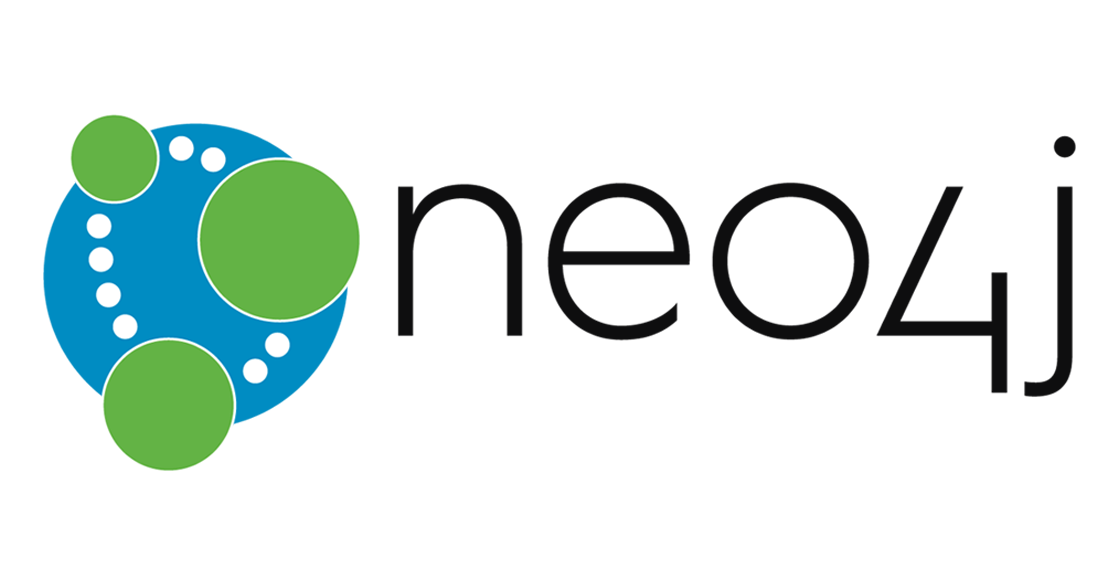

# Banco de Dados de Grafos
Armazenam dados como nós (entidades) e relacionamentos (arestas).

## Características
- Excelente para modelar relações complexas
- Consultas via linguagem Cypher
- Exemplo: Neo4j

## Casos de uso
- Redes sociais
- Recomendação de amigos/produtos
- Detecção de fraudes

In [ ]:
# Instala dependências (execute apenas se necessário)
# !pip install neo4j networkx tqdm

### 1: Criar conta no Neo4j AuraDB (online)

- Acesse: https://neo4j.com/product/auradb/
- Clique em: Start Free ou Get Stated Free
- Crie uma conta
- Crie uma instancia

In [33]:
from neo4j import GraphDatabase, basic_auth
import sys
import pandas as pd
from datetime import date, timedelta
import random

# Ajuste conforme a instancia criada
NEO4J_URI="neo4j+ssc://ab2a0bb9.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="xno7vGQVa-xZZG-VqIYrGJNQNovUzDMZ38Bdvtagyjw"
NEO4J_DATABASE="neo4j"
AURA_INSTANCEID="ab2a0bb9"
AURA_INSTANCENAME="Instance01"

def test_connection(uri=NEO4J_URI, user=NEO4J_USERNAME, password=NEO4J_PASSWORD):
    try:  
        driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))  # Cria o driver para conectar ao Neo4j
        with driver.session() as session:  # Abre uma sessão de comunicação com o banco
            r = session.run("RETURN 1 AS ok")  # Executa uma consulta simples de teste
            print("Conexão OK:", r.single()["ok"])  # Imprime o resultado retornado
        driver.close()  # Fecha explicitamente o driver
    except Exception as e:  # Captura qualquer erro que ocorra
        print("Erro de conexão:", e, file=sys.stderr)  # Exibe o erro no standard error (saída padrão de erros)
        raise  # Relança a exceção para depuração

test_connection()  # Chama a função para testar a conexão

Conexão OK: 1


### 2: Modelagem básica
- **Nós**: `:Pessoa`, `:Produto`, `:Node` (genérico)  
- **Relacionamentos**: `:AMIGO_DE`, `:COMPROU`, `:CONNECTED`  
- Use propriedades em nós/relacionamentos (`nome`, `idade`, `peso`, `timestamp`).  
- Crie índices/constraints em propriedades frequentemente buscadas (ex: `:Pessoa(nome)`, `:Product(sku)`).

In [34]:
driver = GraphDatabase.driver(NEO4J_URI, auth=basic_auth(NEO4J_USERNAME, NEO4J_PASSWORD))

In [35]:
with driver.session() as s:  # Abre uma sessão com o banco Neo4j e a referencia como 's'
    
    # Apaga todos os nós do grafo e seus relacionamentos
    s.run("MATCH (n) DETACH DELETE n") 
    
    # Cria uma regra de restrição de unicidade para o campo 'nome' em nós do tipo Pessoa, se ainda não existir
    s.run("""CREATE CONSTRAINT pessoa_nome_unico IF NOT EXISTS
        FOR (p:Pessoa)
        REQUIRE p.nome IS UNIQUE
    """) 

    # Cria um índice para o campo 'id' em nós do tipo Node, se ainda não existir
    s.run("""
        CREATE INDEX node_id_index IF NOT EXISTS
        FOR (n:Node)
        ON (n.id)
    """) 

print("Limpeza de nós e índices criados.")  # Informa no console que a limpeza e a criação de índices foram concluídas

Limpeza de nós e índices criados.


#### Constraints

São **regras de integridade** aplicadas ao grafo.
Elas garantem que os dados obedeçam certas condições.

Em resumo:
- servem para garantir consistência
- impedem duplicações, propriedades faltantes ou violações de regras
- algumas criam índices automaticamente

In [36]:
with driver.session() as s:
    constraints = s.run("SHOW CONSTRAINTS").data()

df_constraints = pd.DataFrame(constraints)
df_constraints

,id,name,type,entityType,labelsOrTypes,properties,ownedIndex,propertyType
0,3,pessoa_nome_unico,UNIQUENESS,NODE,[Pessoa],[nome],pessoa_nome_unico,None


#### Indexes

São **estruturas de aceleração de busca**.
Eles permitem que o Neo4j encontre nós ou relacionamentos rapidamente, sem percorrer todo o grafo.

Em resumo:

- servem para otimizar performance
- aceleram MATCH, WHERE e MERGE
- funcionam como o índice de um livro

In [37]:
with driver.session() as s:
    indexes = s.run("SHOW INDEXES").data()

df_indexes = pd.DataFrame(indexes)
df_indexes

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,1,index_1b9dcc97,ONLINE,100.0,LOOKUP,RELATIONSHIP,None,None,token-lookup-1.0,None,2025-12-04T23:04:14.544000000+00:00,6
1,0,index_460996c0,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2025-12-04T23:01:28.039000000+00:00,6
2,4,node_id_index,ONLINE,100.0,RANGE,NODE,[Node],[id],range-1.0,None,None,0
3,2,pessoa_nome_unico,ONLINE,100.0,RANGE,NODE,[Pessoa],[nome],range-1.0,pessoa_nome_unico,2025-12-04T23:07:25.377000000+00:00,1593


#### Listar Labels existentes

In [38]:
with driver.session() as s:
    result = s.run("CALL db.labels()")
    print([r["label"] for r in result])

['Pessoa', 'Node']


### 3: CRUD básico em Cypher

Os exemplos a seguir mostram como criar nós e relacionamentos, alterar propriedades e deletar nós.


#### Limpar nós

In [39]:
with driver.session() as s:
    s.run("MATCH (n) DETACH DELETE n")
    print("Todos os nós foram apagados.")

Todos os nós foram apagados.


#### Criar e ler nós

In [40]:
with driver.session() as s:
    # Criar nós com parâmetros
    s.run("CREATE (:Pessoa {nome:$n, idade:$i})", n="Davi", i=19) # Cria um nó do tipo Pessoa 
    s.run("CREATE (:Pessoa {nome:$n, idade:$i})", n="Matheus", i=18)
    
    # Ler nós
    res = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome, p.idade AS idade")
    print("Pessoas:", [dict(r) for r in res])

Pessoas: [{'nome': 'Davi', 'idade': 19}, {'nome': 'Matheus', 'idade': 18}]


#### Atualizar propriedade

In [41]:
with driver.session() as s:
    # Atualizar propriedade
    s.run("MATCH (p:Pessoa {nome:$n}) SET p.idade = $i RETURN p", n="Davi", i=31)

    # Ler nós
    res = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome, p.idade AS idade")
    print("Pessoas:", [dict(r) for r in res])

Pessoas: [{'nome': 'Davi', 'idade': 31}, {'nome': 'Matheus', 'idade': 18}]


#### Criar relacionamento

In [42]:
with driver.session() as s:
    s.run("MATCH (a:Pessoa {nome:$a}), (b:Pessoa {nome:$b}) CREATE (a)-[:AMIGO_DE {desde: date()}]->(b)", a="Davi", b="Matheus")
    # MATCH: Localiza dois nós Pessoa, um com nome igual ao parâmetro $a e outro com nome igual ao parâmetro $b
    # CREATE: Cria um relacionamento AMIGO_DE de 'a' para 'b' com propriedade 'desde' igual à data atual

#### Listar Relacionamentos existentes

In [43]:
with driver.session() as s:
    result = s.run("CALL db.relationshipTypes()")
    print([r["relationshipType"] for r in result])

['AMIGO_DE']


#### Visualizar relacionamento com NetworkX + Matplotlib

In [ ]:
#!pip install networkx

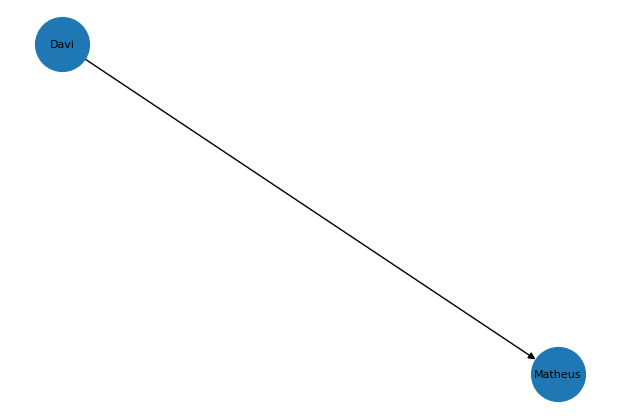

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

# Buscar nós e relacionamentos
with driver.session() as s:
    query = """
    MATCH (a:Pessoa)-[r:AMIGO_DE]->(b:Pessoa)
    RETURN a.nome AS source, b.nome AS target
    """
    rows = s.run(query).data()

# Construir grafo em memória
G = nx.DiGraph()
for row in rows:
    G.add_edge(row["source"], row["target"])

# Plotar
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)  # layout automático
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8)
plt.axis("off")
plt.show()

#### Popular banco

In [45]:
pessoas = [
    ("Rafael", 31),
    ("Gabriel", 25),
    ("Paulo", 29),
    ("Yasmin", 40),
    ("Carlos", 35),
    ("Julia", 28),
    ("Nicolas", 32),
    ("Giovana", 26),
    ("Amanda",18),
]

relacionamentos = [
    ("Giovana", "Carlos", "AMIGO_DE"),
    ("Carlos", "Amanda", "AMIGO_DE"),
    ("Amanda", "Rafael", "AMIGO_DE"),
    ("Rafael", "Paulo", "AMIGO_DE"),
    ("Paulo", "Nicolas", "AMIGO_DE"),
    ("Paulo", "Yasmin", "FAMILIAR"),
    ("Rafael", "Gabriel", "FAMILIAR"),
    ("Carlos", "Nicolas", "CONHECIDO"),
    ("Gabriel", "Paulo", "CONHECIDO"),
    ("Gabriel", "Julia", "AMIGO_DE"),
]

with driver.session() as s:

    # Limpar grafo (opcional)
    s.run("MATCH (n) DETACH DELETE n")

    # Criar nós
    for nome, idade in pessoas:
        s.run("CREATE (:Pessoa {nome:$n, idade:$i})", n=nome, i=idade)

    # Criar relacionamentos
    for a, b, tipo in relacionamentos:
        s.run(
            f"""
            MATCH (x:Pessoa {{nome:$a}}), (y:Pessoa {{nome:$b}})
            CREATE (x)-[:{tipo} {{desde: date()}}]->(y)
            """,
            a=a, b=b
        )
    
    # Atualização de propriedades (exemplos)
    s.run("MATCH (p:Pessoa {nome:'Rafael'}) SET p.idade = 41")
    s.run("MATCH (p:Pessoa {nome:'Amanda'}) SET p.cidade = 'São Paulo'")
    s.run("MATCH (p:Pessoa {nome:'Giovana'}) SET p.email = 'gigi@email.com'")

    # Ler dados
    res = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome, p.idade AS idade, p.cidade AS cidade, p.email").data()
    df = pd.DataFrame(res)
df

,nome,idade,cidade,p.email
0,Rafael,41,None,None
1,Gabriel,25,None,None
2,Paulo,29,None,None
3,Yasmin,40,None,None
4,Carlos,35,None,None
5,Julia,28,None,None
6,Nicolas,32,None,None
7,Giovana,26,None,gigi@email.com
8,Amanda,18,São Paulo,None


#### Visualizar relacionamentos

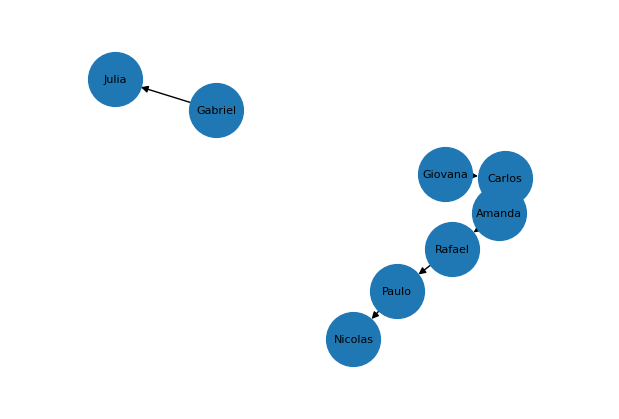

In [46]:
import networkx as nx              # Importa a biblioteca NetworkX para trabalhar com grafos em memória
import matplotlib.pyplot as plt    # Importa o matplotlib.pyplot para gerar gráficos e visualizações

# Buscar nós e relacionamentos
with driver.session() as s:
    # Define a consulta Cypher que busca relações AMIGO_DE entre pessoas, retornando nomes de origem e destino
    query = """
    MATCH (a:Pessoa)-[r:AMIGO_DE]->(b:Pessoa)
    RETURN a.nome AS source, b.nome AS target
    """
    # Executa a consulta no Neo4j e obtém o resultado como lista de dicionários em 'rows'
    rows = s.run(query).data()

# Construir grafo em memória
G = nx.DiGraph()                  # Cria um grafo direcionado (DiGraph) em memória usando NetworkX
for row in rows:                  # Itera sobre cada linha retornada da consulta ao banco
    G.add_edge(row["source"],     # Adiciona uma aresta no grafo do nó de origem
               row["target"])     # para o nó de destino, usando os nomes retornados em 'source' e 'target'


# Plotar
plt.figure(figsize=(6, 4))        # Cria uma nova figura para o gráfico, com tamanho 6x4 polegadas
pos = nx.spring_layout(G)         # Calcula automaticamente as posições dos nós usando o layout de força (spring layout)
nx.draw(G,                        # Desenha o grafo 'G' na figura atual
        pos,                      # Usa as posições calculadas em 'pos' para os nós
        with_labels=True,         # Exibe os rótulos (nomes dos nós) no gráfico
        node_size=1500,           # Define o tamanho dos nós em pixels aproximados
        font_size=8)              # Define o tamanho da fonte dos rótulos dos nós
plt.margins(0.2)                  # Aumenta as margens em torno do grafo para evitar corte dos nós
plt.axis("off")                   # Remove os eixos da figura para deixar apenas o grafo visível
plt.show()                        # Exibe a figura na tela com o grafo desenhado

#### Visualizar todos os nós, mesmo aqueles que não possuem relacionamento

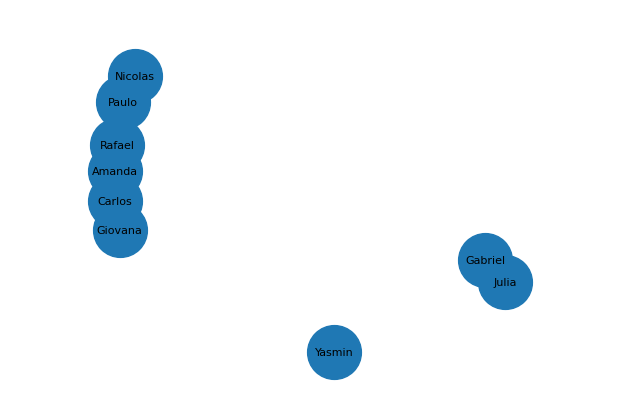

In [47]:
with driver.session() as s:
    nodes = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome").data()
    rels = s.run("""
        MATCH (a:Pessoa)-[r:AMIGO_DE]->(b:Pessoa)
        RETURN a.nome AS source, b.nome AS target
    """).data()

G = nx.DiGraph()                                      # Cria um grafo direcionado em memória usando NetworkX

for n in nodes:                                       # Percorre cada item da lista de nós retornados do Neo4j
    G.add_node(n["nome"])                             # Adiciona cada pessoa como um nó do grafo usando seu nome como identificador

for r in rels:                                        # Percorre cada relacionamento retornado
    G.add_edge(r["source"], r["target"])              # Adiciona uma aresta direcionada entre as pessoas origem e destino no grafo


plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8)
plt.margins(0.2)             
plt.axis("off")
plt.show()

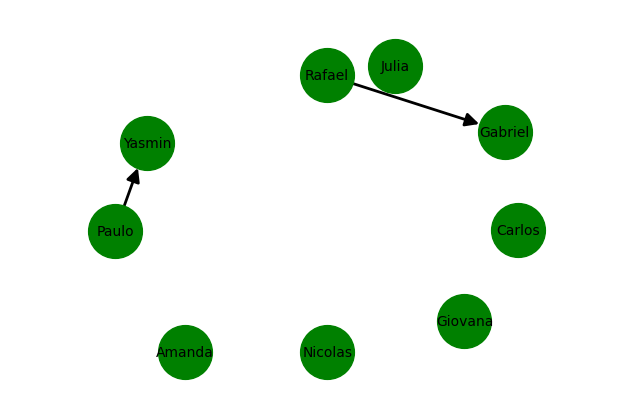

In [48]:
with driver.session() as s:
    nodes = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome").data()
    rels = s.run("""
        MATCH (a:Pessoa)-[r:FAMILIAR]->(b:Pessoa)
        RETURN a.nome AS source, b.nome AS target
    """).data()

G = nx.DiGraph()

for n in nodes:
    G.add_node(n["nome"])

for r in rels:
    G.add_edge(r["source"], r["target"])

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, k=1.5) # k define a distância alvo entre nós
nx.draw(G, pos, with_labels=True,
        node_size=1500,
        font_size=10,
        node_color='green',
        arrowsize=20,        # seta maior
        width=2)             # aresta mais grossa
plt.margins(0.2)             # Aumenta as margens em torno do grafo para evitar corte dos nós
plt.axis("off")
plt.show()

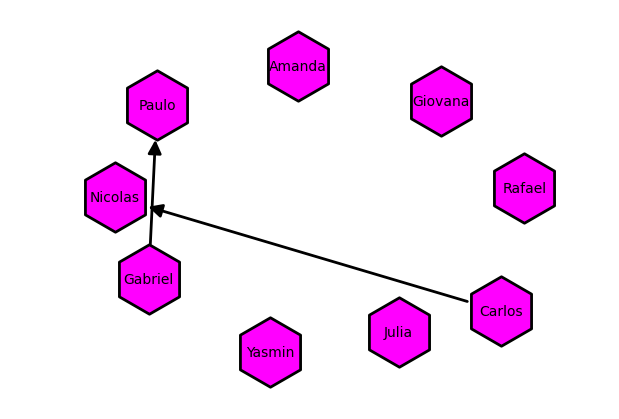

In [49]:
with driver.session() as s:
    nodes = s.run("MATCH (p:Pessoa) RETURN p.nome AS nome").data()
    rels = s.run("""
        MATCH (a:Pessoa)-[r:CONHECIDO]->(b:Pessoa)
        RETURN a.nome AS source, b.nome AS target
    """).data()

G = nx.DiGraph()
for n in nodes:
    G.add_node(n["nome"])
for r in rels:
    G.add_edge(r["source"], r["target"])

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, k=2.5) # k define a distância alvo entre nós
nx.draw(G, pos, with_labels=True,
        node_size=2500,
        font_size=10,
        node_color='magenta',
        node_shape="h",        # quadrado
        edgecolors="black",    # cor da borda
        linewidths=2,          # espessura da borda
        arrowsize=20,        
        width=2)             
plt.margins(0.2)            
plt.axis("off")
plt.show()

### Visualização interativa com PyVis (HTML)

In [27]:
!pip install pyvis

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   --------------------------- ------------ 524.3/756.0 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 756.0/756.0 kB 2.4 MB/s eta 0:00:00


In [29]:
from pyvis.network import Network

with driver.session() as s:
    rows = s.run("""
        MATCH (a:Pessoa)-[r:AMIGO_DE]->(b:Pessoa)
        RETURN a.nome AS source, b.nome AS target
    """).data()

net = Network(height="500px", width="800px", notebook=True, directed=True)

# Adicionar nós e arestas
for row in rows:
    src = row["source"]
    tgt = row["target"]
    net.add_node(src, label=src)
    net.add_node(tgt, label=tgt)
    net.add_edge(src, tgt, label="AMIGO_DE")

net.show("grafo_pessoas.html")

grafo_pessoas.html


### E se o número de nós for muito grande?

In [50]:
def criar_grafo_sintetico(driver, n_pessoas=100, seed=42):
    random.seed(seed)

    profissoes = [
        "Engenheiro de Dados",
        "Analista de Sistemas",
        "Cientista de Dados",
        "Gestor de Projetos",
        "Analista de Qualidade",
        "Técnico de Manutenção",
        "Professor",
        "Consultor",
    ]

    cidades = [
        "São Paulo",
        "Campinas",
        "Jundiaí",
        "Santos",
        "São José dos Campos",
        "Sorocaba",
    ]

    interesses = [
        "Machine Learning",
        "IoT",
        "Big Data",
        "Visão Computacional",
        "DevOps",
        "Automação Industrial",
        "Gestão Ágil",
        "Analytics",
    ]

    tipos_rel = ["AMIGO_DE", "COLEGA", "FAMILIAR", "CONHECE"]

    with driver.session() as s:
        # Limpar banco (cuidado, aqui apaga tudo)
        s.run("MATCH (n) DETACH DELETE n")

        # Constraint de unicidade em nome, padrão Neo4j 5
        s.run("""
            CREATE CONSTRAINT pessoa_nome_unico IF NOT EXISTS
            FOR (p:Pessoa)
            REQUIRE p.nome IS UNIQUE
        """)

        # Gerar lista de pessoas com propriedades
        pessoas = []
        for i in range(1, n_pessoas + 1):
            nome = f"Pessoa{i}"
            idade = random.randint(20, 60)
            profissao = random.choice(profissoes)
            cidade = random.choice(cidades)
            grupo = random.randint(1, 4)  # comunidades 1 a 4
            inter = random.sample(interesses, k=random.randint(1, 3))
            pessoas.append(
                {
                    "nome": nome,
                    "idade": idade,
                    "profissao": profissao,
                    "cidade": cidade,
                    "grupo": grupo,
                    "interesses": inter,
                }
            )

        # Criar nós no Neo4j
        for p in pessoas:
            s.run(
                """
                CREATE (:Pessoa {
                    nome: $nome,
                    idade: $idade,
                    profissao: $profissao,
                    cidade: $cidade,
                    grupo: $grupo,
                    interesses: $interesses
                })
                """,
                **p
            )

        # Criar relacionamentos
        # Mais chance de ligação dentro do mesmo grupo
        rel_count = 0
        base_date = date(2020, 1, 1)

        for i in range(len(pessoas)):
            for j in range(i + 1, len(pessoas)):
                p1 = pessoas[i]
                p2 = pessoas[j]

                mesma_comunidade = p1["grupo"] == p2["grupo"]
                if mesma_comunidade:
                    prob = 0.18  # probabilidade maior dentro do grupo
                else:
                    prob = 0.04  # probabilidade menor entre grupos

                if random.random() < prob:
                    tipo = random.choice(tipos_rel)
                    dias = random.randint(0, 365 * 5)
                    d = base_date + timedelta(days=dias)

                    query = f"""
                    MATCH (a:Pessoa {{nome: $nome1}}),
                          (b:Pessoa {{nome: $nome2}})
                    CREATE (a)-[:{tipo} {{desde: date($d)}}]->(b)
                    """

                    s.run(
                        query,
                        nome1=p1["nome"],
                        nome2=p2["nome"],
                        d=d.isoformat()
                    )
                    rel_count += 1

        print(f"Grafo sintético criado com {len(pessoas)} nós e {rel_count} relacionamentos.")

# Chamar a função
criar_grafo_sintetico(driver, n_pessoas=100, seed=42)

Grafo sintético criado com 100 nós e 369 relacionamentos.


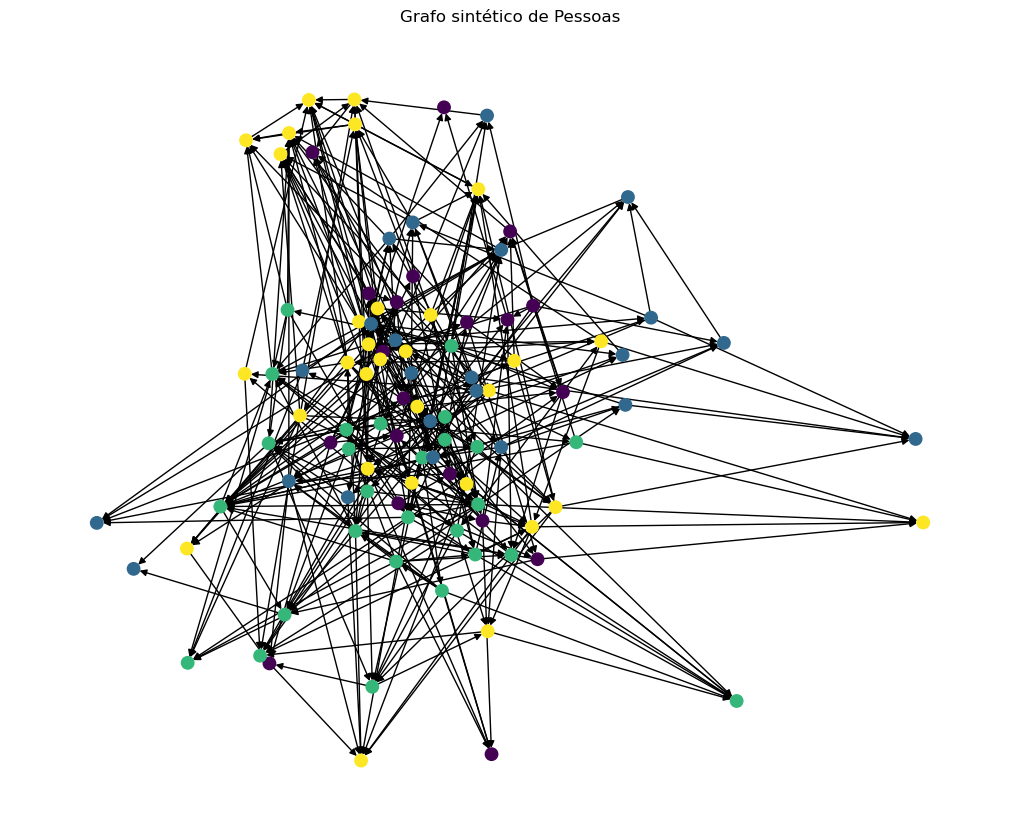

In [51]:
with driver.session() as s:
    rows = s.run("""
        MATCH (a:Pessoa)-[r]->(b:Pessoa)
        RETURN a.nome AS source,
               b.nome AS target,
               type(r) AS tipo,
               a.grupo AS grupo_source,
               b.grupo AS grupo_target
    """).data()

G = nx.DiGraph()

for row in rows:
    src = row["source"]
    tgt = row["target"]
    tipo = row["tipo"]
    g_src = row["grupo_source"]
    g_tgt = row["grupo_target"]

    # Nós com atributo de grupo
    G.add_node(src, grupo=g_src)
    G.add_node(tgt, grupo=g_tgt)

    # Aresta com tipo
    G.add_edge(src, tgt, tipo=tipo)

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, k=0.3, iterations=50)

# Cor por comunidade
grupos = nx.get_node_attributes(G, "grupo")
cores = [grupos[n] for n in G.nodes()]  # só para diferenciar por número

nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=80,
    node_color=cores,
    font_size=8,
    arrowsize=10,
)

plt.title("Grafo sintético de Pessoas")
plt.axis("off")
plt.show()

## E se o número de nós for realmente grande?
### Estratégia de inserção em massa

Para inserir um grafo sintético grande (ex.: 10k nós, 50k arestas), há duas abordagens:

1. **Via Python + bolt** (usando transações em lotes):
   - Gera nós em batches (ex.: 1000 por transação).
   - Para arestas, usar matching por propriedade indexada (ex.: `id`) ou criar mapas temporários.

2. **Import em massa** (`neo4j-admin import`):
   - Gera CSVs de nós/arestas e usa `neo4j-admin import` (muito mais rápido para datasets grandes).
   
Aqui, vamos fazer uma implementação via Python com `networkx` para gerar o grafo e inserir em batches.

In [52]:
from tqdm import tqdm                                  # Importa tqdm, biblioteca usada para criar barras de progresso em loops

# Parâmetros (ajuste conforme memória/tempo)
N_NODES = 10000                                        # Define a quantidade de nós que o grafo sintético terá
N_EDGES = 50000                                        # Define a quantidade total de arestas a serem criadas no grafo

# Cria um grafo aleatório usando o modelo Erdős–Rényi (G(n,m))
G = nx.gnm_random_graph(n=N_NODES,                     # n = número de nós
                        m=N_EDGES,                     # m = número de arestas
                        seed=42,                       # seed = semente para reprodutibilidade (gera o mesmo grafo sempre)
                        directed=False)                # directed=False significa que o grafo é não-direcionado
                                                     
                                                     
# Exibe quantos nós e quantas arestas foram realmente gerados pelo grafo                    
print("Nós:", G.number_of_nodes(), "Arestas:", G.number_of_edges())                             

Nós: 10000 Arestas: 50000


### Inserir nós em batches usando UNWIND (mais eficiente que criar um por um)

In [53]:
BATCH_SIZE = 1000  # Define o tamanho do lote (batch) de nós que será enviado ao Neo4j por operação

with driver.session() as s:                           
    nodes = [{"id": int(n)} for n in range(G.number_of_nodes())] # Cria uma lista de dicionários, cada um representando um nó com campo 'id'
                                                                                          
    # Usa tqdm para exibir uma barra de progresso enquanto itera sobre os lotes
    # range percorre de 0 ao total de nós, pulando de BATCH_SIZE em BATCH_SIZE
    for i in tqdm(range(0, len(nodes), BATCH_SIZE), desc="Inserindo nós (batches)"):
        batch = nodes[i:i+BATCH_SIZE]  # Seleciona um lote (slice) da lista de nós. Exemplo: nós 0–999, depois 1000–1999, e assim por diante
        
        # UNWIND Expande a lista 'batch' em linhas individuais.
        s.run("UNWIND $batch AS row CREATE (n:Node {id: row.id})", batch=batch) # Envia o parâmetro 'batch' para dentro da query Cypher                            
 
print("Inserção de nós concluída.") 

Inserindo nós (batches): 100%|█████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.80it/s]

Inserção de nós concluída.


### Inserir arestas usando UNWIND + MATCH

In [54]:
edges = list(G.edges())  # Converte todas as arestas do grafo G em uma lista de tuplas (u, v). Cada tupla representa uma aresta entre os nós u e v
BATCH_SIZE = 5000  # Define o número de arestas que serão enviadas ao Neo4j por operação (lote)
                                                     
with driver.session() as s:                          

    for i in tqdm(range(0, len(edges), BATCH_SIZE), desc="Inserindo arestas (batches)"):
        batch = [{"u": int(u), "v": int(v)} for u,v in edges[i:i+BATCH_SIZE]]  #Cria um lote de dicionários, onde cada dicionário representa uma aresta
        s.run("UNWIND $batch AS row MATCH (a:Node {id: row.u}), (b:Node {id: row.v}) CREATE (a)-[:CONNECTED]->(b)", batch=batch)    
print("Inserção de arestas concluída.")

Inserindo arestas (batches): 100%|█████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.84it/s]

Inserção de arestas concluída.


### Reconstrução do grafo a partir da base Neo4j

In [55]:
G_db = nx.Graph()                        # Cria um grafo não direcionado em memória, usando NetworkX,
with driver.session() as s:              
    # Define a consulta Cypher que encontra todas as arestas CONNECTED entre nós Node e retorna os ids dos nós origem (source) e destino (target).
    query = """
    MATCH (a:Node)-[:CONNECTED]->(b:Node)
    RETURN a.id AS source, b.id AS target
    """                                  
    result = s.run(query)                # Executa a query no Neo4j e retorna um iterador de registros.

    for record in result:                # Percorre cada registro retornado pela consulta.
        src = record["source"]           # Extrai o valor da coluna 'source' (id do nó origem).
        tgt = record["target"]           # Extrai o valor da coluna 'target' (id do nó destino).
        G_db.add_edge(src, tgt)          # Adiciona uma aresta no grafo NetworkX entre os nós src e tgt,
                                         # recriando no Python a mesma estrutura presente no Neo4j.

print("Nós em G_db:", G_db.number_of_nodes())        # Exibe quantos nós o grafo reconstruído possui.
print("Arestas em G_db:", G_db.number_of_edges())    # Exibe quantas arestas o grafo reconstruído possui.

Nós em G_db: 10000
Arestas em G_db: 50000


### Análise do grafo reconstruído (G_db)

In [56]:
import numpy as np

degrees = [deg for _, deg in G_db.degree()] # Percorre todos os nós do grafo G_db e coleta apenas os graus (o número de conexões de cada nó).
print("Número de nós:", G_db.number_of_nodes())
print("Número de arestas:", G_db.number_of_edges())
print("Grau médio:", np.mean(degrees)) # Calcula a média dos graus (conectividade média dos nós)
print("Grau máximo:", np.max(degrees)) # Calcula o maior grau encontrado entre todos os nós
print("Grau mínimo:", np.min(degrees)) # Calcula o menor grau encontrado entre todos os nós

Número de nós: 10000
Número de arestas: 50000
Grau médio: 10.0
Grau máximo: 24
Grau mínimo: 1


##### Grau mínimo = 1 significa que existe um nó com apenas uma conexão

### Distribuição da quantidade de conexões por nó

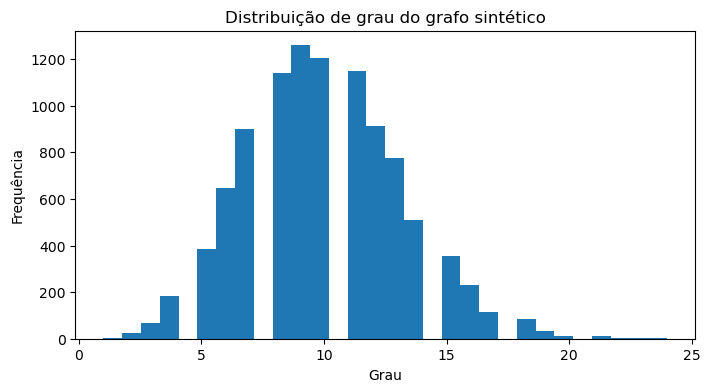

In [57]:
import matplotlib.pyplot as plt

degrees = [deg for _, deg in G_db.degree()]

plt.figure(figsize=(8, 4))
plt.hist(degrees, bins=30)
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.title("Distribuição de grau do grafo sintético")
plt.show()

### Amostra de nós

Tecnicamente, **é possível plotar um grafo com 10.000 nós e 50.000 arestas**, mas **totalmente ineficaz**, pois produziria um grande borrão:

In [58]:
N_SAMPLE = 200  # ajuste conforme ficar legível

# Seleciona aleatoriamente N_SAMPLE nós do grafo e retorna um iterável de nós, que é convertido em lista
sample_nodes = random.sample(list(G_db.nodes()), N_SAMPLE)

subG = G_db.subgraph(sample_nodes).copy() # Cria um subgrafo induzido pelos nós sorteados

print("Subgrafo com", subG.number_of_nodes(), "nós e", subG.number_of_edges(), "arestas") # Imprime quantos nós e quantas arestas existem no subgrafo gerado

Subgrafo com 200 nós e 22 arestas


### Visualizar amostra

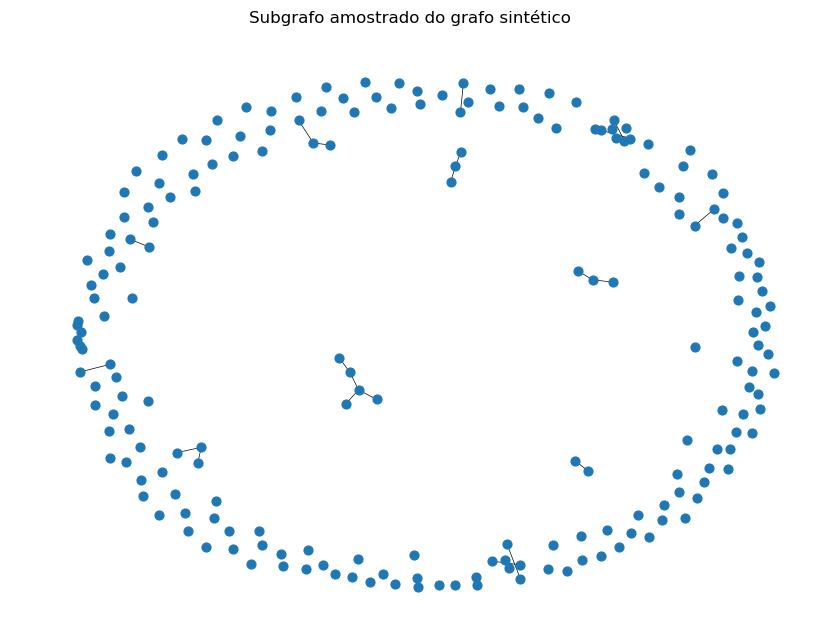

In [59]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subG, k=0.15, iterations=50)
nx.draw(subG, pos, node_size=40, width=0.5, with_labels=False)
plt.title("Subgrafo amostrado do grafo sintético")
plt.axis("off")
plt.show()

In [60]:
from pyvis.network import Network

# Cria um objeto Network que irá representar o grafo visual
net = Network(height="600px", width="100%", notebook=True) # notebook=True habilita integração com notebooks (Jupyter/Colab)

for u, v in subG.edges():
    net.add_node(u, label=str(u)) # Adiciona o nó 'u' à visualização, usando seu próprio valor como rótulo
    net.add_node(v, label=str(v)) # Adiciona também o nó 'v' com rótulo correspondente
    net.add_edge(u, v) # Adiciona uma aresta (não direcionada) entre os nós 'u' e 'v'

net.show("subgrafo_sintetico.html")

subgrafo_sintetico.html


### Exemplo: obter vizinhos do nó 0

In [61]:
with driver.session() as s:
    res = s.run("MATCH (n:Node {id:0})-[:CONNECTED]->(v) RETURN v.id AS vizinhos LIMIT 100")
    vizinhos = [r["vizinhos"] for r in res]
    print("Vizinhos (até 100) do nó 0:", vizinhos)

    # Grau do nó 1
    deg = s.run("MATCH (n:Node {id:1})-[:CONNECTED]->(v) RETURN count(v) AS grau").single()["grau"]
    print("Grau do nó 1:", deg)

    # Shortest path entre 0 e 100 (limitar comprimento máximo)
    path_res = s.run("""
        MATCH (a:Node {id:0}), (b:Node {id:100})
        MATCH p = shortestPath((a)-[*..10]-(b))
        RETURN [n IN nodes(p) | n.id] AS caminho
    """)
    for r in path_res:
        print("Caminho (0 -> 100):", r["caminho"])

Vizinhos (até 100) do nó 0: [1100, 1472, 4053, 4971, 5410, 5549, 7976, 8141]
Grau do nó 1: 16
Caminho (0 -> 100): [0, 5410, 4188, 3166, 982, 100]


### Exercício: Recomendação simples (friends-of-friends)
Enunciado: para um nó `X`, retorne nós que são amigos de amigos (2 saltos) que não sejam já vizinhos diretos.


In [62]:
def friends_of_friends(node_id, limit=20):
    with driver.session() as s:
        res = s.run("""
            MATCH (a:Node {id:$id})-[:CONNECTED]->()-[:CONNECTED]->(fof)
            WHERE NOT (a)-[:CONNECTED]->(fof) AND fof.id <> $id
            RETURN DISTINCT fof.id AS fof_id LIMIT $limit
        """, id=node_id, limit=limit)
        return [r["fof_id"] for r in res]

print("Friends of friends para 0:", friends_of_friends(0, limit=10))

Friends of friends para 0: [2054, 2258, 3126, 4305, 4670, 4832, 4919, 5138, 6659, 8313]


### Visualização
- Destacar o nó alvo em uma cor.
- Destacar vizinhos diretos em outra cor.
- Destacar friends of friends recomendados em uma terceira cor.
- Visualizar apenas o subgrafo local para não virar uma “bola de pelos”

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_friends_of_friends(node_id, limit_fof=20):
    with driver.session() as s:
        # 1. Buscar nó alvo, vizinhos diretos e friends of friends
        data = s.run("""
            MATCH (a:Node {id:$id})
            OPTIONAL MATCH (a)-[:CONNECTED]->(n:Node)
            OPTIONAL MATCH (a)-[:CONNECTED]->(:Node)-[:CONNECTED]->(fof:Node)
            WHERE fof.id <> $id AND NOT (a)-[:CONNECTED]->(fof)
            RETURN a.id AS a_id,
                   collect(DISTINCT n.id) AS neighbors,
                   collect(DISTINCT fof.id) AS fofs
        """, id=node_id).single()

        if not data:
            print(f"Nó {node_id} não encontrado.")
            return

        a_id = data["a_id"]
        neighbors = data["neighbors"] or []
        fofs = (data["fofs"] or [])[:limit_fof]

        # Conjunto de nós que vamos mostrar
        all_nodes = set([a_id]) | set(neighbors) | set(fofs)

        # 2. Buscar arestas apenas entre esses nós para montar o subgrafo
        rels = s.run("""
            MATCH (x:Node)-[:CONNECTED]->(y:Node)
            WHERE x.id IN $ids AND y.id IN $ids
            RETURN x.id AS source, y.id AS target
        """, ids=list(all_nodes)).data()

    # 3. Construir grafo em memória
    G = nx.Graph()
    for nid in all_nodes:
        if nid == a_id:
            role = "target"
        elif nid in neighbors:
            role = "neighbor"
        elif nid in fofs:
            role = "fof"
        else:
            role = "other"

        G.add_node(nid, role=role)

    for r in rels:
        G.add_edge(r["source"], r["target"])

    # 4. Definir cores por tipo de nó
    color_map = []
    for n in G.nodes(data=True):
        role = n[1].get("role")
        if role == "target":
            color_map.append("red")        # nó alvo
        elif role == "neighbor":
            color_map.append("lightblue")  # vizinho direto
        elif role == "fof":
            color_map.append("lightgreen") # recomendação
        else:
            color_map.append("gray")

    # 5. Layout e plotagem
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.3, iterations=50)

    nx.draw(
        G,
        pos,
        node_color=color_map,
        node_size=120,
        width=0.6,
        with_labels=True,
        font_size=7
    )

    # Pequena legenda manual
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="red",        label="Nó alvo"),
        Patch(facecolor="lightblue",  label="Vizinhos diretos"),
        Patch(facecolor="lightgreen", label="Friends of friends (recomendados)"),
    ]
    plt.legend(handles=legend_elements, loc="best")

    plt.title(f"Friends of friends para o nó {node_id}")
    plt.axis("off")
    plt.show()

Friends of friends para 0: [2054, 2258, 3126, 4305, 4670, 4832, 4919, 5138, 6659, 8313]


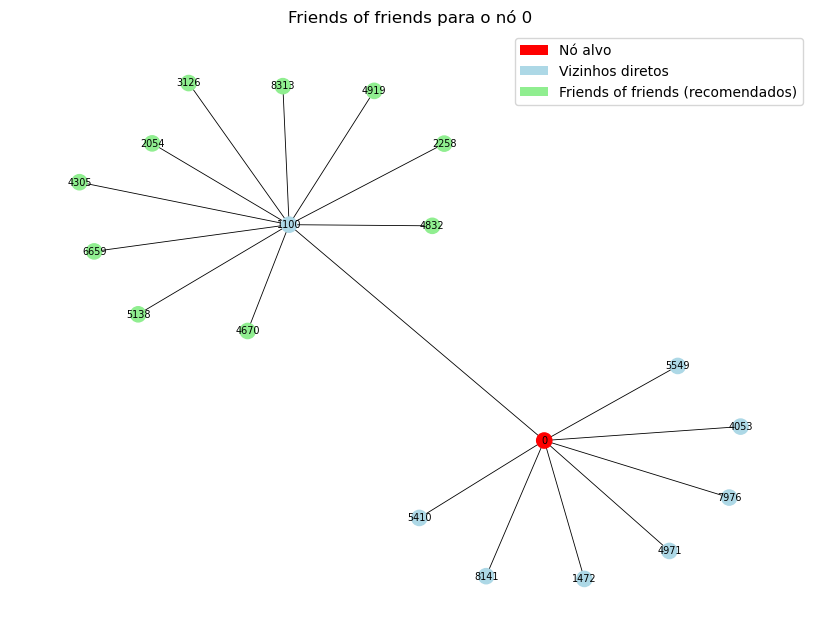

In [64]:
print("Friends of friends para 0:", friends_of_friends(0, limit=10))
visualize_friends_of_friends(0, limit_fof=10)

# Exercício
## Amigos em múltiplos saltos, ciclos e caminhos mínimos

Considere um grafo de pessoas e relações de amizade armazenado no Neo4j, onde:

- cada pessoa é representada como um nó com o label `Person`
- cada amizade é representada por um relacionamento direcionado `:FRIEND`

Seu objetivo é construir um grafo simples e, em seguida, explorar consultas relacionadas a múltiplos saltos, ciclos e caminhos mínimos.

---

### Parte A: Construção do grafo

Crie ao menos oito pessoas, por exemplo:

```text
Bruno, Diego, Erica, Flavio, Gustavo, João, Miriã, Rodrigo
```

Em seguida, crie relacionamentos `:FRIEND` obedecendo às seguintes estruturas:

1. **Cadeia linear**  
   ```text
   Bruno → Diego → Erica → Flavio
   ```

2. **Ciclo**  
   ```text
   Erica → Gustavo → João → Erica
   ```

3. **Ramificação**  
   ```text
   Diego → Miriã
   Miriã → Rodrigo
   ```

Certifique-se de que:

- há pessoas acessíveis a partir de **Bruno** em 1 salto, 2 saltos e 3 saltos  
- o grafo não é totalmente conectado (pelo menos uma pessoa com poucos amigos)

Explore as cores e os formatos de nó para personalizar o seu grafo:

| Símbolo | Forma                                                                      |
| ------- | -------------------------------------------------------------------------- |
| "o"     | círculo (default)                                                          |
| "s"     | quadrado                                                                   |
| "^"     | triângulo para cima                                                        |
| "v"     | triângulo para baixo                                                       |
| ">"     | triângulo para direita                                                     |
| "<"     | triângulo para esquerda                                                    |
| "d"     | diamante                                                                   |
| "p"     | pentágono                                                                  |
| "h"     | hexágono                                                                   |
| "*"     | estrela (em algumas versões funciona como marcador especial do matplotlib) |

---

### Parte B: Amigos em 2 e 3 saltos

#### 4. Amigos em exatamente 2 saltos de Bruno

Escreva uma consulta Cypher que retorne todas as pessoas que são amigas de amigos de Bruno, ou seja, alcançáveis por **exatamente 2 saltos**, excluindo:

- Bruno  
- os amigos diretos de Bruno  

**Dica:**

```cypher
MATCH (b:Person {name:'Bruno'})-[:FRIEND]->()-[:FRIEND]->(fof)
RETURN DISTINCT fof.name
```

---

#### 5. Amigos em exatamente 3 saltos de Bruno

Escreva uma consulta Cypher que retorne as pessoas que estão a **3 saltos** de Bruno, excluindo:

- Bruno  
- amigos diretos  
- amigos em 2 saltos  

**Dica:**  
Use caminhos `[:FRIEND*3]` ou filtre pessoas já encontradas em saltos menores.

---

### Parte C: Detecção de ciclos

#### 6. Encontrar ciclos de amizade

Escreva uma consulta Cypher que identifique **ciclos** envolvendo qualquer pessoa, por exemplo, ciclos que incluam Erica.

**Dica:**

```cypher
MATCH p = (n:Person)-[:FRIEND*3..6]->(n)
RETURN p
```

(Depois trate duplicidades se desejar.)

---

### Parte D: Caminhos mais curtos

### 7. Caminho mais curto entre Bruno e Rodrigo

Escreva uma consulta Cypher que encontre o **shortest path** entre Bruno e Rodrigo, retornando:

- os nomes no caminho  
- o comprimento do caminho  

**Dica:**

```cypher
MATCH p = shortestPath(
    (a:Person {name:'Bruno'})-[:FRIEND*]-(b:Person {name:'Rodrigo'})
)
RETURN p
```

---

### 8. Pessoas alcançáveis em até 3 saltos

Escreva uma consulta que, a partir de Bruno, retorne:

- todas as pessoas alcançáveis em **até 3 saltos**  
- a menor distância (quantidade de saltos) até cada uma  

**Dica:**  
Use caminhos `[:FRIEND*1..3]` e agregação por menor comprimento.

---

## Parte E: Interpretação

Responda:

9. O que significa ser amigo em 1, 2 ou 3 saltos neste grafo?  
10. Como a presença de ciclos pode afetar recomendações de amigos?  
11. Por que caminhos mínimos são importantes em:  
    - sistemas de recomendação  
    - propagação de informações  
    - análise de redes sociais  


In [76]:
pip install neo4j py2neo networkx matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [77]:
from neo4j import GraphDatabase

uri = "neo4j+ssc://ab2a0bb9.databases.neo4j.io"
user = "neo4j"
password = "xno7vGQVa-xZZG-VqIYrGJNQNovUzDMZ38Bdvtagyjw"

driver = GraphDatabase.driver(uri, auth=(user, password))

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()

In [78]:
run_query("MATCH (n) DETACH DELETE n;")
print("Banco limpo.")

Banco limpo.


In [79]:
query_create = """
CREATE (br:Person {name:'Bruno'}),
       (di:Person {name:'Diego'}),
       (er:Person {name:'Erica'}),
       (fl:Person {name:'Flavio'}),
       (gu:Person {name:'Gustavo'}),
       (jo:Person {name:'João'}),
       (mi:Person {name:'Miriã'}),
       (ro:Person {name:'Rodrigo'});
"""
run_query(query_create)

query_edges = """
MATCH (br:Person {name:'Bruno'}),
      (di:Person {name:'Diego'}),
      (er:Person {name:'Erica'}),
      (fl:Person {name:'Flavio'}),
      (gu:Person {name:'Gustavo'}),
      (jo:Person {name:'João'}),
      (mi:Person {name:'Miriã'}),
      (ro:Person {name:'Rodrigo'})
CREATE (br)-[:FRIEND]->(di),
       (di)-[:FRIEND]->(er),
       (er)-[:FRIEND]->(fl),

       (er)-[:FRIEND]->(gu),
       (gu)-[:FRIEND]->(jo),
       (jo)-[:FRIEND]->(er),

       (di)-[:FRIEND]->(mi),
       (mi)-[:FRIEND]->(ro);
"""

run_query(query_edges)

print("Grafo criado no Neo4j.")

Grafo criado no Neo4j.


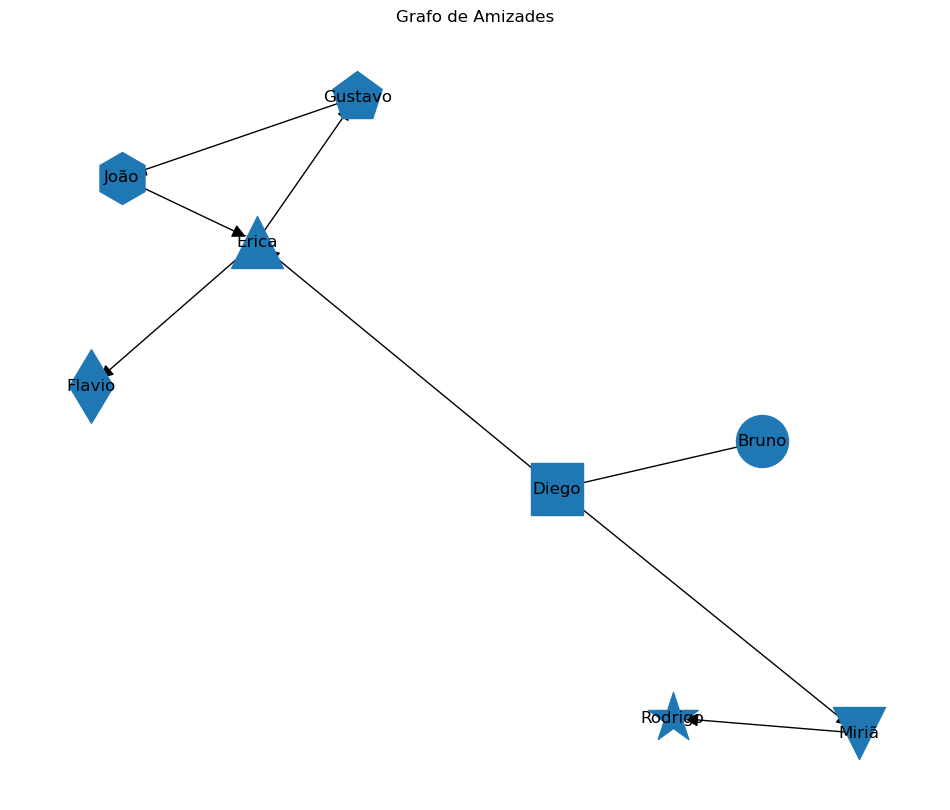

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

# Criando grafo direcionado
G = nx.DiGraph()

people = ["Bruno", "Diego", "Erica", "Flavio", "Gustavo", "João", "Miriã", "Rodrigo"]
G.add_nodes_from(people)

edges = [
    ("Bruno", "Diego"),
    ("Diego", "Erica"),
    ("Erica", "Flavio"),

    ("Erica", "Gustavo"),
    ("Gustavo", "João"),
    ("João", "Erica"),

    ("Diego", "Miriã"),
    ("Miriã", "Rodrigo")
]
G.add_edges_from(edges)

# Formatos de nós personalizados
node_shapes = {
    "Bruno": "o",
    "Diego": "s",
    "Erica": "^",
    "Flavio": "d",
    "Gustavo": "p",
    "João": "h",
    "Miriã": "v",
    "Rodrigo": "*"
}

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12,10))

for shape in set(node_shapes.values()):
    shape_nodes = [n for n in G.nodes if node_shapes[n] == shape]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=shape_nodes,
        node_shape=shape,
        node_size=1400,
        label=shape
    )

nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title("Grafo de Amizades")
plt.axis("off")
plt.show()

In [81]:
query_2 = """
MATCH (b:Person {name:'Bruno'})-[:FRIEND]->()-[:FRIEND]->(fof)
WHERE fof.name <> 'Bruno'
  AND NOT (b)-[:FRIEND]->(fof)
RETURN DISTINCT fof.name AS dois_saltos;
"""

run_query(query_2)

[{'dois_saltos': 'Erica'}, {'dois_saltos': 'Miriã'}]

In [82]:
query_3 = """
MATCH (b:Person {name:'Bruno'})-[:FRIEND*3]->(p)
WHERE p.name <> 'Bruno'
  AND NOT (b)-[:FRIEND*1..2]->(p)
RETURN DISTINCT p.name AS tres_saltos;
"""

run_query(query_3)

[{'tres_saltos': 'Rodrigo'},
 {'tres_saltos': 'Gustavo'},
 {'tres_saltos': 'Flavio'}]

In [83]:
query_cycles = """
MATCH p = (n:Person)-[:FRIEND*3..6]->(n)
RETURN n.name AS pessoa, p;
"""

run_query(query_cycles)

[{'pessoa': 'Erica',
  'p': [{'name': 'Erica'},
   'FRIEND',
   {'name': 'Gustavo'},
   'FRIEND',
   {'name': 'João'},
   'FRIEND',
   {'name': 'Erica'}]},
 {'pessoa': 'Gustavo',
  'p': [{'name': 'Gustavo'},
   'FRIEND',
   {'name': 'João'},
   'FRIEND',
   {'name': 'Erica'},
   'FRIEND',
   {'name': 'Gustavo'}]},
 {'pessoa': 'João',
  'p': [{'name': 'João'},
   'FRIEND',
   {'name': 'Erica'},
   'FRIEND',
   {'name': 'Gustavo'},
   'FRIEND',
   {'name': 'João'}]}]

In [84]:
query_shortest = """
MATCH p = shortestPath(
    (a:Person {name:'Bruno'})-[:FRIEND*]-(b:Person {name:'Rodrigo'})
)
RETURN [n IN nodes(p) | n.name] AS caminho,
       length(p) AS tamanho;
"""

run_query(query_shortest)

[{'caminho': ['Bruno', 'Diego', 'Miriã', 'Rodrigo'], 'tamanho': 3}]

In [85]:
query_reach = """
MATCH (b:Person {name:'Bruno'})-[:FRIEND*1..3]->(p)
WITH p, min(length(shortestPath((b)-[:FRIEND*]->(p)))) AS distancia
RETURN p.name AS pessoa, distancia
ORDER BY distancia, pessoa;
"""

run_query(query_reach)

[{'pessoa': 'Diego', 'distancia': 1},
 {'pessoa': 'Erica', 'distancia': 2},
 {'pessoa': 'Miriã', 'distancia': 2},
 {'pessoa': 'Flavio', 'distancia': 3},
 {'pessoa': 'Gustavo', 'distancia': 3},
 {'pessoa': 'Rodrigo', 'distancia': 3}]

In [86]:
print("""
🔹 Amigo em 1 salto:
   — É um amigo direto: Bruno → Diego.

🔹 Amigo em 2 saltos:
   — Amigo de amigo: Bruno → Diego → Erica.

🔹 Amigo em 3 saltos:
   — Amigo do amigo do amigo, ainda conectado, mas distante.

🔹 Ciclos:
   — Criam loops sociais que podem inflar recomendações e indicar grupos fechados.

🔹 Caminhos mínimos são importantes para:
   • Sistemas de recomendação → sugerir contatos relevantes.
   • Propagação de informações → entender velocidade e alcance.
   • Análise de redes sociais → medir proximidade e detectar hubs.
""")


🔹 Amigo em 1 salto:
   — É um amigo direto: Bruno → Diego.

🔹 Amigo em 2 saltos:
   — Amigo de amigo: Bruno → Diego → Erica.

🔹 Amigo em 3 saltos:
   — Amigo do amigo do amigo, ainda conectado, mas distante.

🔹 Ciclos:
   — Criam loops sociais que podem inflar recomendações e indicar grupos fechados.

🔹 Caminhos mínimos são importantes para:
   • Sistemas de recomendação → sugerir contatos relevantes.
   • Propagação de informações → entender velocidade e alcance.
   • Análise de redes sociais → medir proximidade e detectar hubs.

